This notebook analyzes the NYU data in comparison to Sionna simulations from the NIST 28 GHz dataset linked at https://nextg.nist.gov/submissions/47.

In [78]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import sys

sys.path.append(os.path.abspath('./src'))

from scene_generation.core import Scene
from scene_generation.utils import *
from scene_generation.empirical_pathloss_model import pathloss_38901
from scene_generation.unet.unet_model_rt import UNet

from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, PathSolver
from scipy.io import loadmat

# Mitsuba components for advanced scene operation
import mitsuba as mi
import drjit as dr

import seaborn as sns # type: ignore
from scipy import stats
from scipy.spatial import KDTree
from mpl_toolkits.mplot3d import Axes3D

In [79]:
def generate_random_rx_locations(num_candidates, mi_scene, bbox):
    """
    Generate random rx coordinates for a given scene and returns
    the coordinates that are not inside building boundaries.

    """
    ue_height = 1.5

    bbox_min = bbox.min
    bbox_max = bbox.max

    # Extract x, y bounds (avoiding slicing on Mitsuba objects)
    low = [bbox_min.x, bbox_min.y]
    high = [bbox_max.x, bbox_max.y]

    # Generate random x, y coordinates
    rand_xy = np.random.uniform(low=low, high=high, size=(num_candidates, 2))

    # Add constant UE height (z-coordinate)
    candidates = np.column_stack((rand_xy, np.full((num_candidates,), ue_height)))

    # Create a direction vector pointing upwards (towards the sky) 
    # and tile it to match the number of positions
    directions_np = np.tile(np.array([0, 0, 1]), (len(candidates), 1))

    # Ray tracing validation
    rays = mi.Ray3f(
        mi.Vector3f(np.array(candidates, dtype=np.float32).T),
        mi.Vector3f(np.array(directions_np, dtype=np.float32).T)
    )
    si = mi_scene.ray_intersect(rays)
    valid_mask = ~si.is_valid()

    # Filter
    valid_positions = candidates[valid_mask]

    return valid_positions

def find_closest_valid_positions_optimized(invalid_positions, valid_positions, use_2d=True):
    """
    Given a list of rx locations (invalid_positions) that are in buildings due to estimation 
    error, find the closest location from the randomly generated rx locations that are outside
    buildings. 
    """
    
    if len(valid_positions) == 0:
        raise ValueError("No valid positions available!")
    
    if len(invalid_positions) == 0:
        return np.array([]), np.array([]), np.array([])
    
    # Use only x,y coordinates for distance calculation if use_2d=True
    if use_2d:
        valid_coords = valid_positions[:, :2]  # Only x, y
        invalid_coords = invalid_positions[:, :2]  # Only x, y
    else:
        valid_coords = valid_positions
        invalid_coords = invalid_positions
    
    # Build KDTree for fast nearest neighbor search
    tree = KDTree(valid_coords)
    
    # Find closest valid position for each invalid position
    distances, indices = tree.query(invalid_coords)
    
    # Get the actual closest valid positions
    closest_valid_positions = valid_positions[indices]
    
    return closest_valid_positions, distances, indices

Scenes have already been generated with geo2sigmap and the TX location at the center. In order to regenerate scenes follow the Tutorial 1. This method loads the already generated scene mesh to add all the wireless communication elements.

In [80]:

PCI_list = ['KAU', 'COL1', 'COL2']
nyu_data = pd.read_csv('NYU_data.csv')
nyu_data.head()

def manhattan_paths(which_PCI):
    """
    Loads a scene with a transmitter at the center and with
    corresponding rx locations.
    Return:
        nyu_data_filtered: (pd.DataFrame) updated NYU_data.csv file
                            with only the corresponding TX-RX data
        scene: (Sionna Scene)
    """

    scene_dir = "./scenes/Manhattan_{}".format(which_PCI)
    scene = load_scene("./scenes/Manhattan_{}/scene.xml".format(which_PCI))

    # Transmit array (single iso element)
    scene.tx_array = PlanarArray(
        num_rows=1,
        num_cols=1,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern="iso",        # isotropic pattern
        polarization="V"      # vertical polarization
    )

    # Receive array (single dipole element)
    scene.rx_array = PlanarArray(
        num_rows=1,
        num_cols=1,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern="iso",
        polarization="cross"
    )
    rx_height = 1.5

    # TX locations (latitude, longitude) and height
    cell_info_dict = {
        'KAU': { 'loc': (40.7290611, -73.9962500), 'height': 17, 'rel_loc': [3, -3, 17] },
        'COL1': { 'loc': (40.7270944, -73.9974972), 'height': 65, 'rel_loc': [3, 0, 67] },
        'COL2': { 'loc': (40.7268833, -73.9970556), 'height': 65, 'rel_loc': [11, -2, 67] },
    }

    utm_epsg = get_utm_epsg_code_from_gps(
        cell_info_dict[which_PCI]['loc'][1],
        cell_info_dict[which_PCI]['loc'][0],
    )
    # Create a single transmitter.
    # - Positioned at x=0, y=0, z=100, in the unit of meters
    tx = Transmitter(
        name="tx",
        position=cell_info_dict[which_PCI]['rel_loc'],
        orientation=[0, 0, 0]
    )

    # Add the transmitter instance to our scene
    scene.add(tx)

    nyu_data_filtered = nyu_data[nyu_data['TX'] == which_PCI]

    measurement = np.empty([len(nyu_data_filtered["Lat (°)"]), 5])
    nyu_data_filtered.loc[:, "PL (dB)"] = nyu_data_filtered["PL (dB)"].replace('-', np.nan)
    nyu_data_filtered.loc[:, "PL (dB)"] = pd.to_numeric(nyu_data_filtered["PL (dB)"], errors='coerce')
    measurement[:, 0] = nyu_data_filtered["Lat (°)"]
    measurement[:, 1] = nyu_data_filtered["Long (°)"]
    measurement[:, 2] = nyu_data_filtered["PL (dB)"]
    measurement[:, 3] = rx_height # height
    measurement[:, 4] = True # is_outdoor

    # Convert coordinates to relative coordinates to tx
    center_coord_x_utm, center_coord_y_utm, _   = gps_to_utm_xy(
        cell_info_dict[which_PCI]['loc'][1],
        cell_info_dict[which_PCI]['loc'][0],
        utm_epsg)

    for idx, point in enumerate(measurement):
        mea_x_utm, mea_y_utm, _ = gps_to_utm_xy(measurement[idx,1], measurement[idx,0], utm_epsg)
        row = mea_x_utm - center_coord_x_utm
        col =  mea_y_utm - center_coord_y_utm
        
        measurement[idx, 0] = row
        measurement[idx, 1] = col

    ground_truth_list = measurement


    # Obtain the Mitsuba scene object from Sionna scene object 
    mi_scene = scene.mi_scene

    # Calculate scene bounding box excluding the ground plane
    bbox = mi.ScalarBoundingBox3f()
    for shape in mi_scene.shapes():
        if "ground" not in shape.id():
            bbox.expand(shape.bbox())

    candidates = np.column_stack((
        measurement[:, 0],  # UTM-X
        measurement[:, 1],  # UTM-Y
        measurement[:, 3]   # height (e.g. 1.5m)
    ))

    # Create a direction vector pointing upwards (towards the sky) 
    #  and tile it to match the number of positions
    directions_np = np.tile(np.array([0, 0, 1]), (len(measurement), 1))

    # Ray tracing validation
    rays = mi.Ray3f(
        # mi.Vector3f(candidates),
        mi.Vector3f(np.array(candidates, dtype=np.float32).T),
        mi.Vector3f(np.array(directions_np, dtype=np.float32).T)
    )
    si = mi_scene.ray_intersect(rays)
    rx_valid_mask = ~si.is_valid()

    measurement[:, 4] = rx_valid_mask

    # Filter
    rx_invalid_positions = candidates[~rx_valid_mask]

    # Generate random positions to correct rx_invalid_positions
    valid_positions = generate_random_rx_locations(num_candidates=10000, mi_scene=mi_scene, bbox=bbox)

    closest_positions, distances, indices = find_closest_valid_positions_optimized(rx_invalid_positions, valid_positions)


    rx_positions = []
    rx_info = []
    for index, rx_coords in enumerate(ground_truth_list):
        pos = (float(rx_coords[0]), float(rx_coords[1]), rx_height)
        rx_id = nyu_data_filtered.iloc[index]['RX']
        rx_positions.append(pos)
        rx_info.append({'index': index, 'rx_id': rx_id, 'original_pos': pos})

    # Convert to numpy array for validation
    rx_positions_np = np.array(rx_positions)

    relocated_rx_positions = rx_positions_np.copy()
    relocated_rx_positions[~rx_valid_mask] = closest_positions

    # Create receivers with validated/relocated positions
    relocated_count = 0
    for index, rx_info_item in enumerate(rx_info):
        original_pos = rx_info_item['original_pos']
        new_pos = tuple(relocated_rx_positions[index])
        rx_id = rx_info_item['rx_id']
        
        # Check if position was relocated
        if not np.allclose(original_pos, new_pos):
            relocated_count += 1
            print(f"RX {rx_id} relocated from {original_pos} to {new_pos}")
        
        rx = Receiver(
            name=f"rx{rx_id}",
            position=mi.Point3f([float(new_pos[0]), float(new_pos[1]), float(new_pos[2])]),
            orientation=(0, 0, 0)
        )
        scene.add(rx)

    print(f"\nSummary:")
    print(f"- Total receivers: {len(rx_info)}")
    print(f"- Relocated receivers: {relocated_count}")

    # Configure simulation parameters
    scene.frequency = 28e9  
    scene.synthetic_array = True  # Optimize for array calculations

    for radio_material in scene.radio_materials.values():
        radio_material.scattering_coefficient  = 0.4

    return nyu_data_filtered, scene

In [81]:
# Perform ray tracing using PathSolver()
def manhattan_pathsolver(scene):
    solver = PathSolver()
    paths = solver(
        scene, 
        max_depth=3,
        los=True,
        specular_reflection=True,
        diffuse_reflection=True,
        refraction=False,
        samples_per_src=int(1e6)
    )
    return paths

In [82]:
# Parse paths into a structured dataset containing detailed rays information
def create_ray_dataset(paths, frequency, filtered_data):
    """Process raw ray data into pandas DataFrame"""
    dataset = {
        'freq': [],
        'RX': [],
        'type': [],
        'phi_r': [],
        'phi_t': [],
        'theta_r': [],
        'theta_t': [],
        'a':[],
        'tau':[],
    }

    # See sionna.rt.constants.InteractionType
    ray_type_map = {0: "LOS", 1: "SPECULAR", 2: "DIFFUSE", 4: "REFRACTION"}
    
    a = np.asarray(paths.a).squeeze()
    tau = np.asarray(paths.tau).squeeze()
    types = np.asarray(paths.interactions).squeeze()
    mask = np.asarray(paths.valid).squeeze()
    phi_r = np.asarray(paths.phi_r).squeeze()
    phi_t = np.asarray(paths.phi_t).squeeze()
    theta_r = np.asarray(paths.theta_r).squeeze()
    theta_t = np.asarray(paths.theta_t).squeeze()
    
    # Choose polarization index (0 = first polarization, 1 = second polarization)
    pol_idx = 0

    # Extract relevant parameters
    for idx, item in enumerate(mask):
        # Filter out the RX if it has no valid paths
        if np.sum(item==True):
            for sub_idx, sub_item in enumerate(item):
                if sub_item:
                    cur_ray_type = 0
                    num_depths = types.shape[0]
                    for depth_idx in range(num_depths-1, -1, -1):
                        cur_ray_type = types[depth_idx,idx,sub_idx]
                        # print(f"types[{depth_idx},{idx},{sub_idx}]",cur_ray_type)
                        if cur_ray_type != 0:
                            break

                    # Store the list instead of np.array to avoid the space seperator in .csv
                    dataset["freq"].append(frequency)
                    dataset["type"].append(ray_type_map[cur_ray_type])
                    z = np.complex64(a[0,idx,pol_idx, sub_idx] + 1j*a[1, idx,pol_idx, sub_idx]) 
                    dataset["a"].append(z)
                    dataset["tau"].append(tau[idx,sub_idx])
                    dataset["RX"].append(filtered_data.iloc[idx]['RX'])
                    dataset["phi_r"].append(phi_r[idx,sub_idx ])                    
                    dataset["phi_t"].append(phi_t[idx,sub_idx])
                    dataset["theta_r"].append(theta_r[idx,sub_idx])
                    dataset["theta_t"].append(theta_t[idx,sub_idx])
    
    return pd.DataFrame(dataset)

In [83]:
# Normalizing helper functions
def linear(data_db):
    return 10 ** (data_db / 10)

def normalize(data_db):
    data_db_array = data_db.to_numpy(dtype=float)
    data_linear = linear(data_db_array)
    max_val = np.nanmax(data_linear)
    data_linear_norm = data_linear / max_val

    result = np.full_like(data_linear_norm, np.nan)
    valid_mask = (data_linear_norm > 0) & ~np.isnan(data_linear_norm)
    result[valid_mask] = 10 * np.log10(data_linear_norm[valid_mask])
    result[~valid_mask] = 0
    return result

In [84]:
def add_pathgain_df(path_df, filtered_data, threshold_db):
    """ Computes and normalizes the path gain of all receivers """
    path_gain = path_df.groupby('RX')['a'].apply(lambda x: 10 * np.log10(np.power(np.abs(x),2).sum())).reset_index()
    
    # Rename the column for clarity
    path_gain.columns = ['RX', 'Pred PG']

    # Set low path gain values below threshold to lowest value - 5
    path_gain['Pred PG'] = path_gain['Pred PG'].where(path_gain['Pred PG'] >= threshold_db, np.NaN)

    path_gain['Pred PG'] = path_gain['Pred PG'].fillna(path_gain['Pred PG'].min() - 5)
    filtered_data = filtered_data.copy()

    filtered_data['PG (dB)'] = 0 - filtered_data['PL (dB)']

    filtered_data = filtered_data.merge(path_gain[['RX', 'Pred PG']], on='RX', how='left')

    filtered_data['PG (dB)'] = filtered_data['PG (dB)'].fillna(filtered_data['PG (dB)'].min() - 5)
    
    # Currently normalizing to max dB
    filtered_data['Pred PG Norm'] = normalize(filtered_data['Pred PG'])
    filtered_data['PG Norm'] = normalize(filtered_data['PG (dB)'])

    # Fill the NaN values with 0
    filtered_data['Pred PG Norm'] = filtered_data['Pred PG Norm'].fillna(0)
    filtered_data['PG Norm'] = filtered_data['PG Norm'].fillna(0)

    filtered_data['Absolute Error'] = np.abs(
        filtered_data['Pred PG Norm'] - filtered_data['PG Norm']
    )
    return filtered_data

def add_strongest_pathgain(path_df, filtered_data):
    """ Selects the ray with the strongest path gain for each receiver """
    path_df['power'] = np.abs(path_df['a'])**2
    strongest_path = path_df.loc[path_df.groupby('RX')['power'].idxmax()].reset_index(drop=True)
    strongest_path['Pred PG'] = 10 * np.log10(strongest_path['power'])
    filtered_data.loc[:, 'PG (dB)'] = 0 - filtered_data['PL (dB)']

    filtered_data = filtered_data.merge(strongest_path[['RX', 'Pred PG']], on='RX', how='left')

    filtered_data['Pred PG Norm'] = normalize(filtered_data['Pred PG'])
    filtered_data['PG Norm'] = normalize(filtered_data['PG (dB)'])

    filtered_data['Pred PG Norm'] = filtered_data['Pred PG Norm'].fillna(0)
    filtered_data['PG Norm'] = filtered_data['PG Norm'].fillna(0)

    filtered_data['Absolute Error'] = np.abs(
        filtered_data['Pred PG Norm'] - filtered_data['PG Norm']
    )

    return filtered_data

In [85]:
# Generate scenes of each transmitter
KAU_df_filtered, KAU_scene = manhattan_paths(PCI_list[0])
COL1_df_filtered, COL1_scene = manhattan_paths(PCI_list[1])
COL2_df_filtered, COL2_scene = manhattan_paths(PCI_list[2])


2025-08-11 22:36:07 WARN wrk0 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

RX 3 relocated from (-151.01367787551135, -130.00989080779254, 1.5) to (-145.71418036429318, -119.07780002213428, 1.5)
RX 14 relocated from (-15.046252759289928, -79.43010878469795, 1.5) to (-15.846405021442024, -76.15768759167867, 1.5)
RX 16 relocated from (-88.27489693858661, -35.54734382033348, 1.5) to (-85.25314682603448, -33.50961039416865, 1.5)

Summary:
- Total receivers: 24
- Relocated receivers: 3


2025-08-11 22:36:08 WARN wrk0 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

RX 3 relocated from (-48.1840895160567, 89.51045725215226, 1.5) to (-41.264396676164154, 95.1195401206216, 1.5)
RX 14 relocated from (87.78333560016472, 140.09023927524686, 1.5) to (88.92907482267191, 142.3392763203853, 1.5)
RX 16 relocated from (14.55469142086804, 183.97300423961133, 1.5) to (19.832545365992132, 185.45905193359675, 1.5)

Summary:
- Total receivers: 25
- Relocated receivers: 3


2025-08-11 22:36:08 WARN main [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

RX 3 relocated from (-85.74461215350311, 112.51811469625682, 1.5) to (-75.36785796581867, 115.98448846396286, 1.5)
RX 14 relocated from (50.22281296271831, 163.0978967193514, 1.5) to (55.20589549749553, 165.56586646856886, 1.5)
RX 16 relocated from (-23.005831216578372, 206.98066168371588, 1.5) to (-18.2624864248383, 207.84189210197053, 1.5)

Summary:
- Total receivers: 25
- Relocated receivers: 3


In [86]:
# Use sionna to compute paths
KAU_paths = manhattan_pathsolver(KAU_scene)
COL1_paths = manhattan_pathsolver(COL1_scene)
COL2_paths = manhattan_pathsolver(COL2_scene)

Generate the scenes and the simulated ray tracing paths.

In [87]:
#KAU_scene.preview(paths=KAU_paths)

In [88]:
#COL1_scene.preview(paths=COL1_paths)

In [89]:
#COL2_scene.preview(paths=COL2_paths)

Create dataframes to calculate path gain of rays generated by Sionna. <br>
Pred PG      - Sionna path gain <br>
Pred PG Norm - Normalized Sionna path gain <br>
PG (dB).     - NYU dataset path gain <br>
PG Norm      - Normalized NYU dataset path gain

In [90]:
freq = 28e9
KAU_df = create_ray_dataset(KAU_paths, freq, KAU_df_filtered)
# KAU_df = add_strongest_pathgain(KAU_df, KAU_df_filtered)
KAU_df = add_pathgain_df(KAU_df, KAU_df_filtered, -145)

COL1_df = create_ray_dataset(COL1_paths, freq, COL1_df_filtered)
# COL1_df = add_strongest_pathgain(COL1_df, COL1_df_filtered)
COL1_df = add_pathgain_df(COL1_df, COL1_df_filtered, -141)

COL2_df = create_ray_dataset(COL2_paths, freq, COL2_df_filtered)
# COL2_df = add_strongest_pathgain(COL2_df, COL2_df_filtered)
COL2_df = add_pathgain_df(COL2_df, COL2_df_filtered, -141)
combined_df = pd.concat([KAU_df, COL1_df, COL2_df], ignore_index=True)

KAU_data = combined_df.loc[combined_df['TX']=='KAU']

In [91]:
KAU_df

,TX,RX,Lat (°),Long (°),Env.,3D T-R (m),PL (dB),PG (dB),Pred PG,Pred PG Norm,PG Norm,Absolute Error
0,KAU,1,40.727322,-73.997300,N,213,NaN,-154.2,-149.312010,-56.835394,-65.8,8.964606
1,KAU,2,40.727542,-73.997083,N,184,NaN,-154.2,-149.312010,-56.835394,-65.8,8.964606
2,KAU,3,40.727906,-73.998056,N,200,NaN,-154.2,-149.312010,-56.835394,-65.8,8.964606
3,KAU,4,40.728075,-73.998017,N,186,149.2,-149.2,-149.312010,-56.835394,-60.8,3.964606
4,KAU,5,40.726986,-73.998842,N,318,NaN,-154.2,-149.312010,-56.835394,-65.8,8.964606
5,KAU,6,40.729500,-73.997889,N,147,NaN,-154.2,-149.312010,-56.835394,-65.8,8.964606
6,KAU,7,40.729836,-73.997617,N,145,NaN,-154.2,-149.312010,-56.835394,-65.8,8.964606
7,KAU,8,40.729744,-73.997128,N,107,NaN,-154.2,-133.043594,-40.566978,-65.8,25.233022
8,KAU,9,40.730344,-73.998300,N,225,NaN,-154.2,-149.312010,-56.835394,-65.8,8.964606
9,KAU,10,40.728669,-73.995514,N,77,124.2,-124.2,-117.079992,-24.603376,-35.8,11.196624


In [92]:
COL1_df

,TX,RX,Lat (°),Long (°),Env.,3D T-R (m),PL (dB),PG (dB),Pred PG,Pred PG Norm,PG Norm,Absolute Error
0,COL1,1,40.727322,-73.997300,L,31,92.3,-92.3,-119.909821,-5.387001,0.0,5.387001
1,COL1,2,40.727542,-73.997083,N,61,123.8,-123.8,-119.281836,-4.759016,-31.5,26.740984
2,COL1,3,40.727906,-73.998056,L,102,NaN,-153.1,-124.533167,-10.010347,-60.8,50.789653
3,COL1,4,40.728075,-73.998017,N,118,136.4,-136.4,-131.229258,-16.706438,-44.1,27.393562
4,COL1,5,40.726986,-73.998842,N,114,115.6,-115.6,-126.280899,-11.758080,-23.3,11.541920
5,COL1,6,40.729500,-73.997889,N,270,NaN,-153.1,-137.904959,-23.382139,-60.8,37.417861
6,COL1,7,40.729836,-73.997617,N,305,NaN,-153.1,-139.429836,-24.907017,-60.8,35.892983
7,COL1,8,40.729744,-73.997128,N,296,NaN,-153.1,-144.429836,-29.907017,-60.8,30.892983
8,COL1,9,40.730344,-73.998300,N,368,NaN,-153.1,-115.381231,-0.858412,-60.8,59.941588
9,COL1,10,40.728669,-73.995514,N,242,NaN,-153.1,-114.522820,0.000000,-60.8,60.800000


In [93]:
COL2_df

,TX,RX,Lat (°),Long (°),Env.,3D T-R (m),PL (dB),PG (dB),Pred PG,Pred PG Norm,PG Norm,Absolute Error
0,COL2,1,40.727322,-73.997300,L,53,100.8,-100.8,-102.523260,0.000000,0.0,0.000000
1,COL2,2,40.727542,-73.997083,N,73,121.4,-121.4,-118.526373,-16.003113,-20.6,4.596887
2,COL2,3,40.727906,-73.998056,N,142,119.0,-119.0,-118.103762,-15.580502,-18.2,2.619498
3,COL2,4,40.728075,-73.998017,N,155,141.4,-141.4,-119.399576,-16.876316,-40.6,23.723684
4,COL2,5,40.726986,-73.998842,N,151,124.9,-124.9,-130.816240,-28.292980,-24.1,4.192980
5,COL2,6,40.729500,-73.997889,N,299,NaN,-149.5,-128.414993,-25.891733,-48.7,22.808267
6,COL2,7,40.729836,-73.997617,N,332,NaN,-149.5,-144.383326,-41.860065,-48.7,6.839935
7,COL2,8,40.729744,-73.997128,N,318,NaN,-149.5,-144.383326,-41.860065,-48.7,6.839935
8,COL2,9,40.730344,-73.998300,N,399,NaN,-149.5,-144.383326,-41.860065,-48.7,6.839935
9,COL2,10,40.728669,-73.995514,N,237,NaN,-149.5,-111.592903,-9.069643,-48.7,39.630357


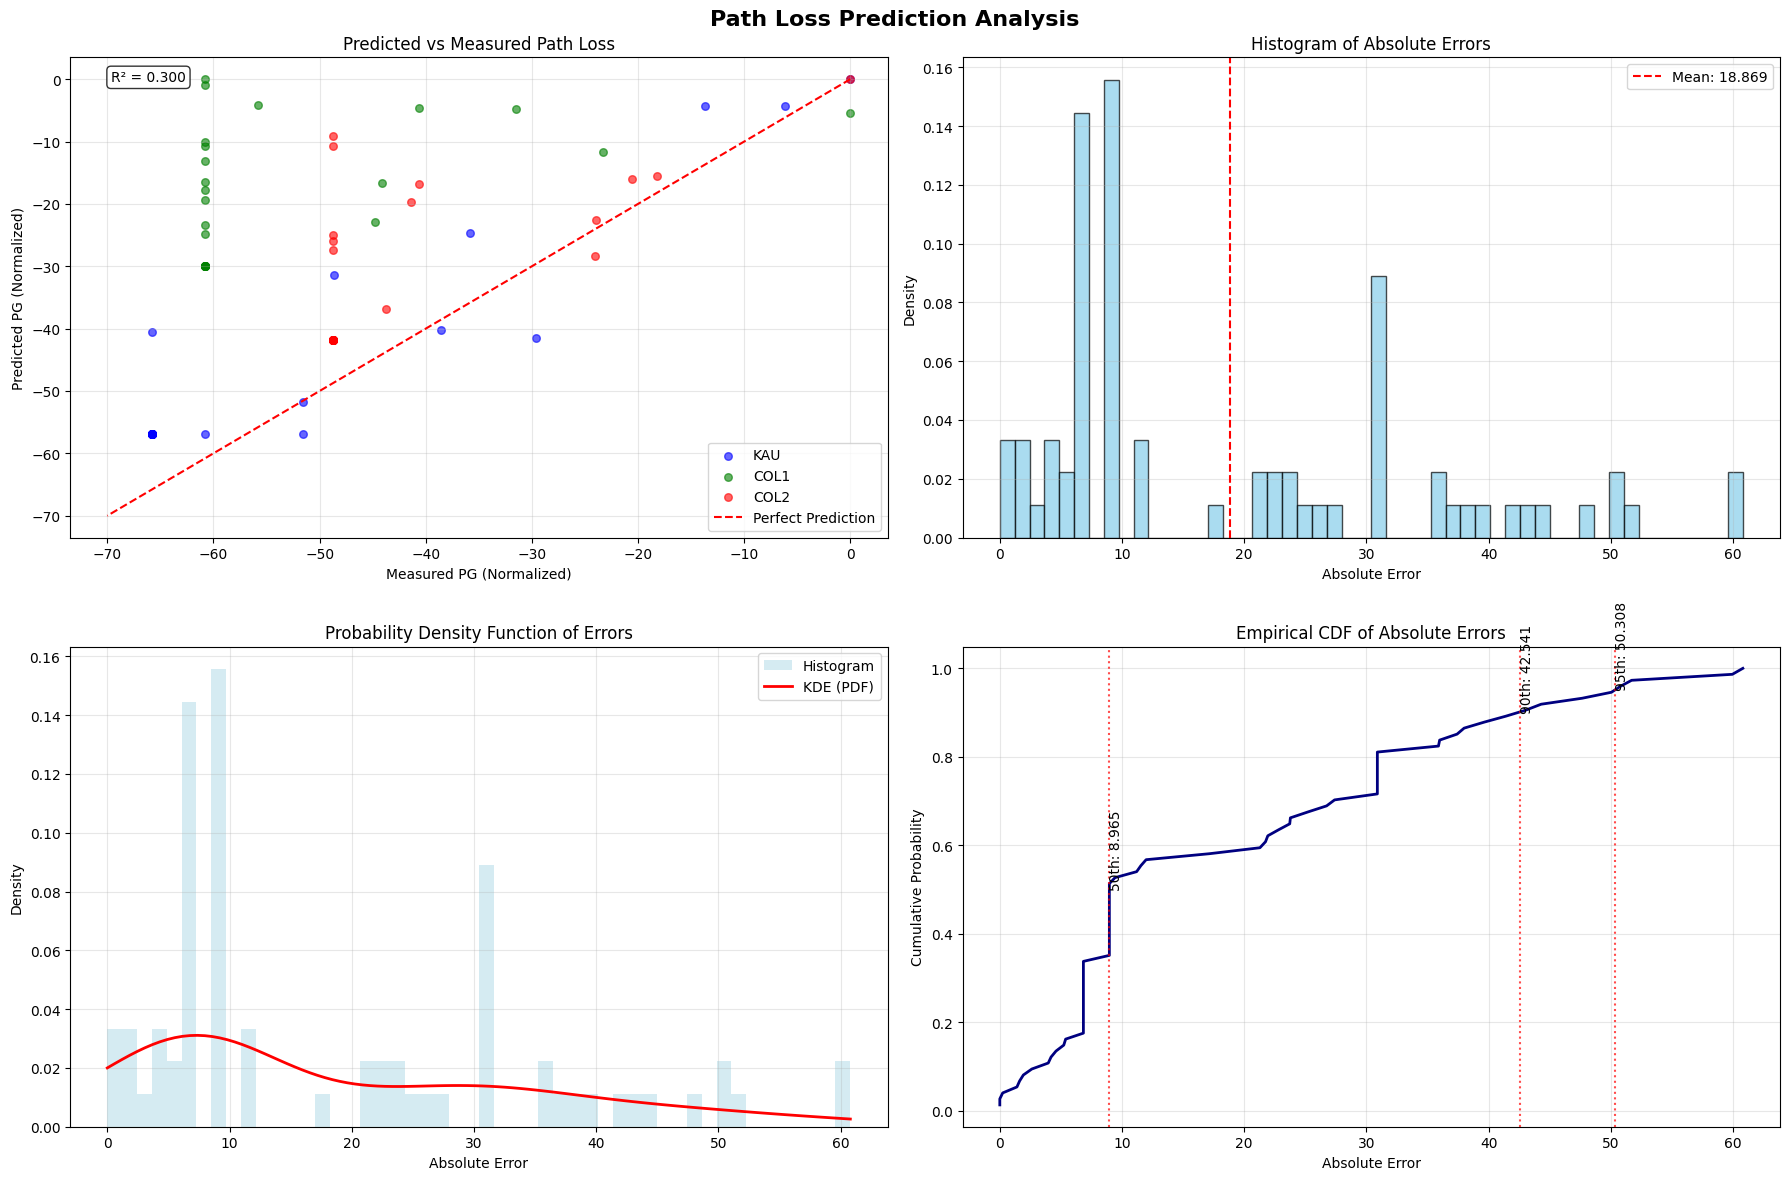

In [94]:
# Create Plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Path Loss Prediction Analysis', fontsize=16, fontweight='bold')

# 1. Scatter plot: Predicted vs Measured (normalized)
axes[0, 0].scatter(KAU_df['PG Norm'], 
                   KAU_df['Pred PG Norm'], 
                   alpha=0.6, s=30, label='KAU', color='blue')
axes[0, 0].scatter(COL1_df['PG Norm'], 
                   COL1_df['Pred PG Norm'], 
                   alpha=0.6, s=30, label='COL1', color='green')
axes[0, 0].scatter(COL2_df['PG Norm'], 
                   COL2_df['Pred PG Norm'], 
                   alpha=0.6, s=30, label='COL2', color='red')
axes[0, 0].plot([0, -70], [0, -70], 'r--', label='Perfect Prediction')
axes[0, 0].set_xlabel('Measured PG (Normalized)')
axes[0, 0].set_ylabel('Predicted PG (Normalized)')
axes[0, 0].set_title('Predicted vs Measured Path Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


# Calculate R² for the plot
r_squared = stats.pearsonr(combined_df['PG Norm'], 
                          combined_df['Pred PG Norm'])[0]**2
axes[0, 0].text(0.05, 0.95, f'R² = {r_squared:.3f}', 
                transform=axes[0, 0].transAxes, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Add statistics to histogram
mean_error = combined_df['Absolute Error'].mean()
std_error = combined_df['Absolute Error'].std()
axes[0, 1].axvline(mean_error, color='red', linestyle='--', 
                   label=f'Mean: {mean_error:.3f}')
axes[0, 1].legend()

# 2. Histogram of Absolute Errors
axes[0, 1].hist(combined_df['Absolute Error'], bins=50, alpha=0.7, 
                color='skyblue', edgecolor='black', density=True)
axes[0, 1].set_xlabel('Absolute Error')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Histogram of Absolute Errors')
axes[0, 1].grid(True, alpha=0.3)

# 3. Empirical CDF (eCDF) of Absolute Errors
sorted_errors = np.sort(combined_df['Absolute Error'])
ecdf_y = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
axes[1, 1].plot(sorted_errors, ecdf_y, linewidth=2, color='navy')
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Empirical CDF of Absolute Errors')
axes[1, 1].grid(True, alpha=0.3)

# Add percentile lines
percentiles = [50, 90, 95]
for p in percentiles:
    value = np.percentile(sorted_errors, p)
    axes[1, 1].axvline(value, color='red', linestyle=':', alpha=0.7)
    axes[1, 1].text(value, p/100, f'{p}th: {value:.3f}', 
                    rotation=90, verticalalignment='bottom')

# 4. PDF estimation using kernel density
axes[1, 0].hist(combined_df['Absolute Error'], bins=50, alpha=0.5, 
                density=True, color='lightblue', label='Histogram')

# Kernel density estimation for smooth PDF
from scipy.stats import gaussian_kde
kde = gaussian_kde(combined_df['Absolute Error'])
x_range = np.linspace(combined_df['Absolute Error'].min(), 
                      combined_df['Absolute Error'].max(), 100)
axes[1, 0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE (PDF)')
axes[1, 0].set_xlabel('Absolute Error')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Probability Density Function of Errors')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [95]:
# Print summary statistics
print("=== PATH LOSS PREDICTION ANALYSIS SUMMARY ===")
print(f"Total number of data points: {len(combined_df)}")
print(f"\nAbsolute Error Statistics:")
print(f"Mean Absolute Error: {mean_error:.4f}")
print(f"Standard Deviation: {std_error:.4f}")
print(f"Median Absolute Error: {np.median(combined_df['Absolute Error']):.4f}")
print(f"90th Percentile Error: {np.percentile(combined_df['Absolute Error'], 90):.4f}")
print(f"95th Percentile Error: {np.percentile(combined_df['Absolute Error'], 95):.4f}")
print(f"Maximum Error: {combined_df['Absolute Error'].max():.4f}")

print(f"\nCorrelation Analysis:")
correlation = stats.pearsonr(combined_df['PG Norm'], 
                            combined_df['Pred PG Norm'])
print(f"Pearson Correlation: {correlation[0]:.4f} (p-value: {correlation[1]:.2e})")
print(f"R-squared: {correlation[0]**2:.4f}")

=== PATH LOSS PREDICTION ANALYSIS SUMMARY ===
Total number of data points: 74

Absolute Error Statistics:
Mean Absolute Error: 18.8686
Standard Deviation: 16.0706
Median Absolute Error: 8.9646
90th Percentile Error: 42.5413
95th Percentile Error: 50.3081
Maximum Error: 60.8000

Correlation Analysis:
Pearson Correlation: 0.5481 (p-value: 4.31e-07)
R-squared: 0.3004


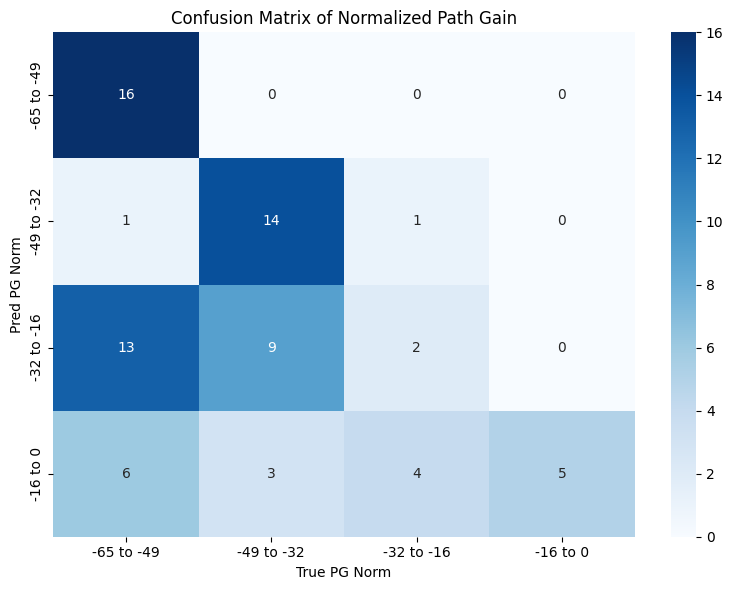

In [96]:
# Confusion Matrix
min_val = min(combined_df['PG Norm'].min(), combined_df['Pred PG Norm'].min())
max_val = max(combined_df['PG Norm'].max(), combined_df['Pred PG Norm'].max())

bin_edges = np.linspace(min_val - 1e-6, max_val + 1e-6, 5)  # 5 bins

true_binned = pd.cut(combined_df['PG Norm'], bins=bin_edges, labels=False, include_lowest=True)
pred_binned = pd.cut(combined_df['Pred PG Norm'], bins=bin_edges, labels=False, include_lowest=True)


combined_df_with_bins = combined_df.copy()
combined_df_with_bins['true_bin'] = true_binned
combined_df_with_bins['pred_bin'] = pred_binned

valid = true_binned.notna() & pred_binned.notna()
combined_df_with_bins = combined_df_with_bins[valid]

true_binned = true_binned[valid]
pred_binned = pred_binned[valid]

conf_matrix = confusion_matrix(pred_binned, true_binned)

# Plot
plt.figure(figsize=(8, 6))
xticks = [f"{int(bin_edges[i])} to {int(bin_edges[i+1])}" for i in range(len(bin_edges) - 1)]
yticks = xticks.copy()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=xticks, yticklabels=yticks)
plt.xlabel('True PG Norm')
plt.ylabel('Pred PG Norm')
plt.title('Confusion Matrix of Normalized Path Gain')
plt.tight_layout()
plt.show()

This is currently looking at the case scenario where Sionna receives a signal but NYU data does not (false positive).

In [97]:
combined_df_with_bins
# false nevative is top right
# false positive is bottom right

false_negative_rx = receivers_true1_pred3 = combined_df_with_bins[
    (combined_df_with_bins['true_bin'] == 0) & 
    (combined_df_with_bins['pred_bin'] == 1)
]['RX'].values

false_negative_rx



array([8])

In [98]:
false_negative_tx = receivers_true1_pred3 = combined_df_with_bins[
    (combined_df_with_bins['true_bin'] == 0) & 
    (combined_df_with_bins['pred_bin'] == 1)
]['TX'].values
false_negative_tx

array(['KAU'], dtype=object)

In [99]:
df = create_ray_dataset(KAU_paths, freq, KAU_df_filtered)

In [100]:
df['Power (dB)'] = 10 * np.log10(np.abs(df['a'])**2)

In [101]:
# Finding delay of the strongest path gain ray
df_rx = df[(df['RX'] == 8) & (df['Power (dB)'] > -150)]
df_rx['tau'] * 1e9

28289    722.084045
Name: tau, dtype: float32

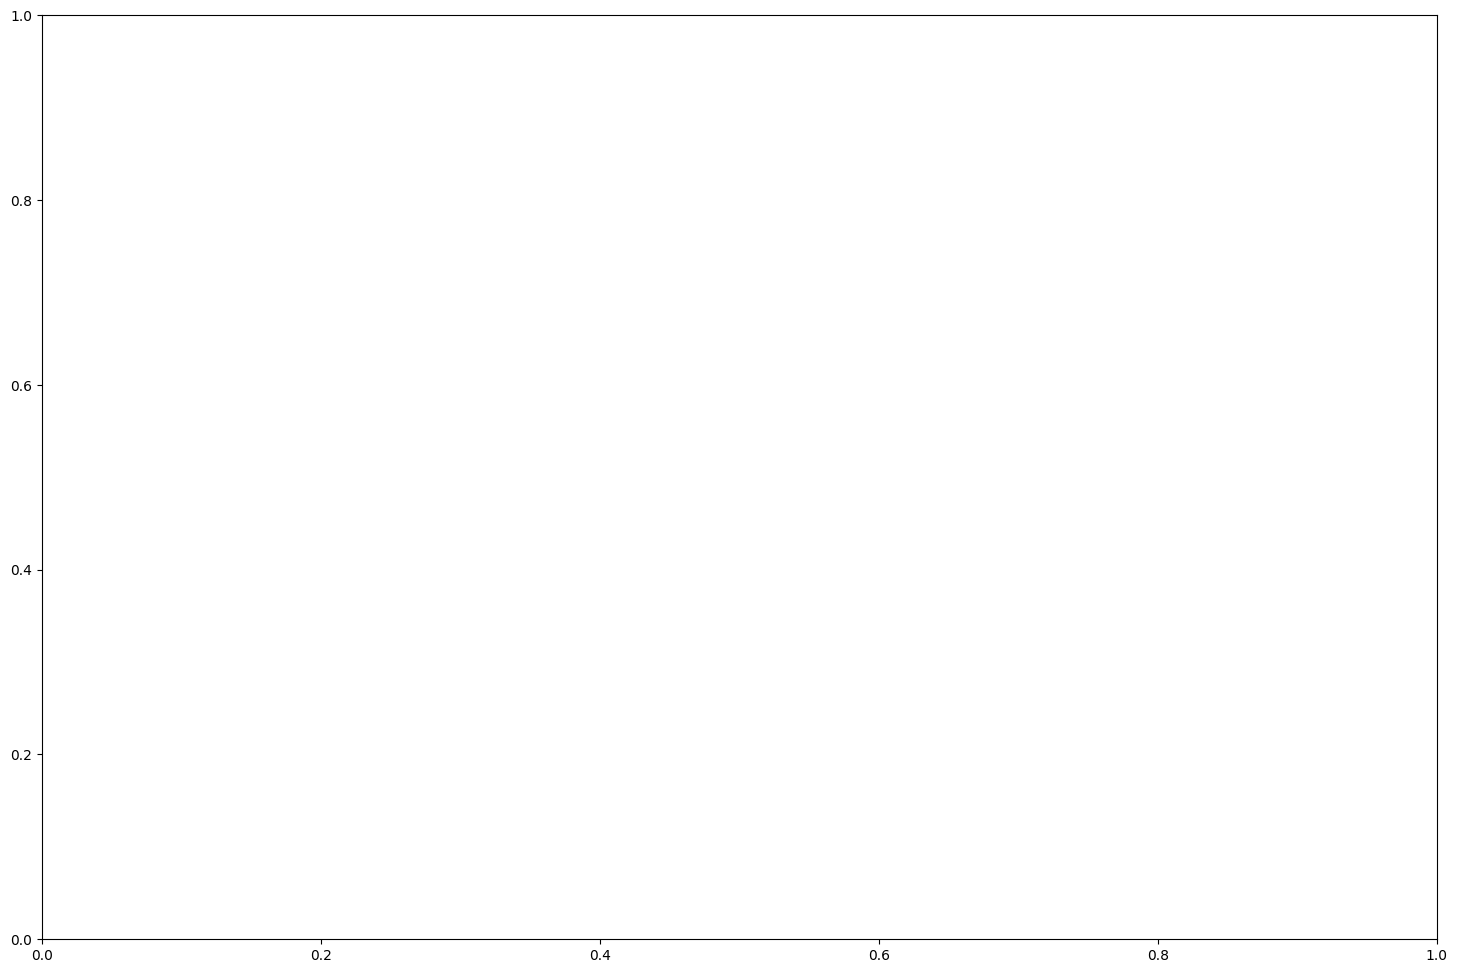

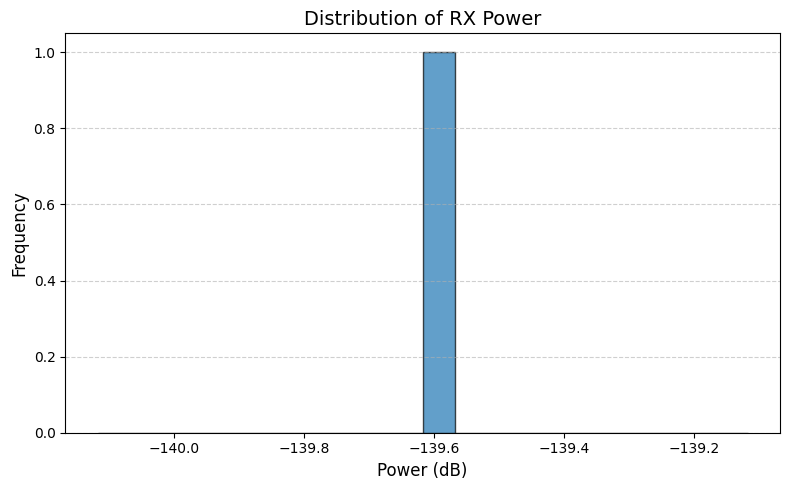

In [102]:
df_rx_filtered = df_rx[df_rx['Power (dB)'] >= -150]
fig, axes = plt.subplots(1, 1, figsize=(18, 12))
plt.figure(figsize=(8, 5))
plt.hist(df_rx_filtered['Power (dB)'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of RX Power', fontsize=14)
plt.xlabel('Power (dB)', fontsize=12)

plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()